In [1]:
# Loading all packages + ignoring warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error as mse
from sklearn import linear_model, tree
import statsmodels.api as statsmodels

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns
import requests, json
from datetime import datetime
from time import time

from scipy.stats import randint as sp_randint

# Contents:



### Data collection 1: Google Trends data
Note: The scraping method is shown here, but it will not work, because the urls changes daily and in an unstructured way. Therefore we here show the code for our scrapes, but we have downloaded and saved a csv of the scrapes which is found in the current working directory.

In [164]:
# urls for data for different keyword searches
url_job = 'https://trends.google.dk/trends/api/widgetdata/multiline?hl=da&tz=-120&req=%7B%22time%22:%222007-01-01+2018-08-29%22,%22resolution%22:%22MONTH%22,%22locale%22:%22da%22,%22comparisonItem%22:%5B%7B%22geo%22:%7B%22country%22:%22DK%22%7D,%22complexKeywordsRestriction%22:%7B%22keyword%22:%5B%7B%22type%22:%22BROAD%22,%22value%22:%22job%22%7D%5D%7D%7D%5D,%22requestOptions%22:%7B%22property%22:%22%22,%22backend%22:%22IZG%22,%22category%22:0%7D%7D&token=APP6_UEAAAAAW4fe6-2dsET3xP7h1Y3OweS11kacFLhU&tz=-120'
url_dagpenge = 'https://trends.google.dk/trends/api/widgetdata/multiline?hl=da&tz=-120&req=%7B%22time%22:%222007-01-01+2018-08-29%22,%22resolution%22:%22MONTH%22,%22locale%22:%22da%22,%22comparisonItem%22:%5B%7B%22geo%22:%7B%22country%22:%22DK%22%7D,%22complexKeywordsRestriction%22:%7B%22keyword%22:%5B%7B%22type%22:%22BROAD%22,%22value%22:%22dagpenge%22%7D%5D%7D%7D%5D,%22requestOptions%22:%7B%22property%22:%22%22,%22backend%22:%22IZG%22,%22category%22:0%7D%7D&token=APP6_UEAAAAAW4ffDqYGsvDiXLzsbRtwEuGUVj_gICFU&tz=-120'
url_kontanthjælp = 'https://trends.google.dk/trends/api/widgetdata/multiline?hl=da&tz=-120&req=%7B%22time%22:%222007-01-01+2018-08-29%22,%22resolution%22:%22MONTH%22,%22locale%22:%22da%22,%22comparisonItem%22:%5B%7B%22geo%22:%7B%22country%22:%22DK%22%7D,%22complexKeywordsRestriction%22:%7B%22keyword%22:%5B%7B%22type%22:%22BROAD%22,%22value%22:%22kontanthj%C3%A6lp%22%7D%5D%7D%7D%5D,%22requestOptions%22:%7B%22property%22:%22%22,%22backend%22:%22IZG%22,%22category%22:0%7D%7D&token=APP6_UEAAAAAW4ffJ7sJM8lV9LeHcUdNOKX43WYeIRWn&tz=-120'
url_akasse = 'https://trends.google.dk/trends/api/widgetdata/multiline?hl=da&tz=-120&req=%7B%22time%22:%222007-01-01+2018-08-29%22,%22resolution%22:%22MONTH%22,%22locale%22:%22da%22,%22comparisonItem%22:%5B%7B%22geo%22:%7B%22country%22:%22DK%22%7D,%22complexKeywordsRestriction%22:%7B%22keyword%22:%5B%7B%22type%22:%22BROAD%22,%22value%22:%22a-kasse%22%7D%5D%7D%7D%5D,%22requestOptions%22:%7B%22property%22:%22%22,%22backend%22:%22IZG%22,%22category%22:0%7D%7D&token=APP6_UEAAAAAW4ffTdu5RMRJshD0S9n7rP1AvC-sah16&tz=-120'
url_jobnet = 'https://trends.google.dk/trends/api/widgetdata/multiline?hl=da&tz=-120&req=%7B%22time%22:%222007-01-01+2018-08-29%22,%22resolution%22:%22MONTH%22,%22locale%22:%22da%22,%22comparisonItem%22:%5B%7B%22geo%22:%7B%22country%22:%22DK%22%7D,%22complexKeywordsRestriction%22:%7B%22keyword%22:%5B%7B%22type%22:%22BROAD%22,%22value%22:%22jobnet%22%7D%5D%7D%7D%5D,%22requestOptions%22:%7B%22property%22:%22%22,%22backend%22:%22IZG%22,%22category%22:0%7D%7D&token=APP6_UEAAAAAW4ffsYDR_Of8TjMQhVk5wt0TMZzRgKuT&tz=-120'

url_list = [url_job, url_dagpenge, url_kontanthjælp, url_akasse, url_jobnet ]

combined_list = []

for j in url_list:
    response = requests.get(j)
    print(response.ok)
    print('-----')
    dict_ = json.loads(response.text.split(")]}\',\n")[1])

    # saving length of the timelineData dict
    dict_length = len(dict_['default']['timelineData'])

    timelinedata_list = [] 

    for i in range(0,dict_length):
        # Extracting value (keyword: 'time')
        time = dict_['default']['timelineData'][i]['time']
    
        year = datetime.utcfromtimestamp(int(time)).strftime('%Y')
        month = datetime.utcfromtimestamp(int(time)).strftime('%m')
        # Extracting value (keyword: 'value'). Pulling out first element, since list with one element.
        value = dict_['default']['timelineData'][i]['value'][0]
    
    
        help_list =[]
        if j == url_list[0]:
            help_list.append(year)
            help_list.append(month)
        help_list.append(value)
        timelinedata_list.append(help_list)
    
    if j == url_list[0]:
        for l in range(0, len(timelinedata_list)):
            
            combined_list.append(timelinedata_list[l])
    else:
        for k in range(0,len(timelinedata_list)):
            combined_list[k].append(timelinedata_list[k][0])

df = pd.DataFrame(combined_list)
df.columns = ['Year', 'Month',
              'GI_job',
              'GI_dagpenge',
              'GI_kontanthjælp', 
              'GI_akasse',
              'GI_jobnet'
             ]

dfGI = df.groupby(['Year', 'Month'], as_index=False).mean()

False
-----


IndexError: list index out of range

In [2]:
# dfGI.to_csv("googledata29082018.csv", index=False)
dfGI = pd.read_csv("googledata29082018.csv")
print(dfGI.head())

   Year  Month  Average_GI_job  Average_GI_dagpenge  Average_GI_kontanthjælp  \
0  2007      1              93                   47                       22   
1  2007      2              84                   35                       22   
2  2007      3              74                   42                       24   
3  2007      4              72                   30                       18   
4  2007      5              74                   32                       24   

   Average_GI_akasse  Average_GI_jobnet  
0                 37                 34  
1                 28                 33  
2                 35                 33  
3                 32                 28  
4                 28                 31  


### Data collection 2: Unemployment rates from Statistics Denmark

In [30]:
# Importing unemployment data from statbank.dk
AKUurl = 'https://api.statbank.dk/v1/data/AKU125/CSV?lang=en&valuePresentation=Value&timeOrder=Descending&delimiter=Semicolon&allowVariablesInHead=true&S%C3%86SON=11&S%C3%86SON=10&BESKSTATUS=LPCT&TID=*'
AKUcsv = pd.read_csv(AKUurl, sep = ";")
unemp_url = 'https://api.statbank.dk/v1/data/AUS07/CSV?lang=en&valuePresentation=Value&timeOrder=Descending&delimiter=Semicolon&allowVariablesInHead=true&YD=TOT&YD=NET&TID=*&SAESONFAK=9&SAESONFAK=22'
raw_unemp = pd.read_csv(unemp_url, sep = ";")

# Reshaping and constructing dummies for filtering
AKUcsv['season_adj'] = np.where(AKUcsv['SÆSON'] == 'Non-seasonally adjusted', 0, 1)
AKUcsv.columns = ['todrop', 'type', 'time', 'rate', 'season_adj']
AKUcsv['type'] = AKUcsv['type'].str.replace(r'rate', r'')
AKU = AKUcsv.drop('todrop', axis=1)
AKU = AKU[AKU['time'] != '2018M07'] # dropping the newest data that got released 31/8 to avoid messup

raw_unemp['season_adj'] = np.where(raw_unemp['SAESONFAK'] == 'Seasonally adjusted figures in percent of the labour force', 1, 0)
raw_unemp.columns = ['type', 'time', 'SAESONFAK', 'rate', 'season_adj']
reg_unemp = raw_unemp.drop('SAESONFAK', axis=1)
reg_unemp = reg_unemp[reg_unemp['time'] != '2018M07']

# Merge data 
df_all_unemp = pd.concat([AKU, reg_unemp], ignore_index=True)

# Convert variable time to date format and sort by date
df_all_unemp['time'] = df_all_unemp['time'].str.replace(r'\D', r' ')
df_all_unemp['time'] = pd.to_datetime(df_all_unemp['time'], format = "%Y %m" )
df_all_unemp = df_all_unemp.sort_values('time')

# Shortening of type names
df_all_unemp['type'] = df_all_unemp['type'].str.replace(r'unemployment', r'unemp')
df_all_unemp['type'] = df_all_unemp['type'].str.strip()
df_all_unemp.head(5)

,type,time,rate,season_adj
827,Net unemp,2007-01-01,3.7,0
826,Net unemp,2007-01-01,3.2,1
137,ILO-unemp,2007-01-01,4.2,0
551,Gross unemp,2007-01-01,4.7,0
275,ILO-unemp,2007-01-01,4.1,1


### Data Structuring 1: Merging data and extracting variables of interest

We first define some parameters for how our final datasets should be constructed:

In [4]:
###-------------User input start----------------###
# Number of lags for explanatory variables
n_lags = 1
# Should be set to 1 for seasonally adjusted unemployment data and 0 otherwise
season_adjustment = 0
# Specify type of unemployment - 'ILO-unemp', 'Net unemp' or 'Gross unemp'
unemp_type = 'Net unemp'
# Number of months from 2007-01 to cut
cut_n_months = 36
###--------------User input end-----------------###

In [23]:
# extraction of the relevant unemployment rate series e.g. uncorrected net unemployment
unemp_rates = df_all_unemp[(df_all_unemp['season_adj']==season_adjustment) & (df_all_unemp['type']==unemp_type)].drop(columns='season_adj')
unemp_rates = unemp_rates.reset_index(drop=True)
unemp_rates.head(3)

,type,time,rate
0,Net unemp,2007-01-01,3.7
1,Net unemp,2007-02-01,3.6
2,Net unemp,2007-03-01,3.3


In [6]:
# Copying unemployment rates for creating first difference variable later
unemp_rates_first_diff = unemp_rates.copy()

### Data Structuring 2: Lagging our variables

In [7]:
# Aadd unemp_rates lagged 1 period to our GI data
dfGI['unemp_lag1'] = unemp_rates['rate'].shift(n_lags)

# Create a combined dataframe with lagged GIs
# NB: the prefix "Average_" on the GI headers on the RHSs should be ignored. 
df_comb = dfGI.copy()
df_comb['GI_job_lag1'] = df_comb['Average_GI_job'].shift(n_lags)
df_comb['GI_dagpenge_lag1'] = df_comb['Average_GI_dagpenge'].shift(n_lags)
df_comb['GI_kontanthjælp_lag1'] = df_comb['Average_GI_kontanthjælp'].shift(n_lags)
df_comb['GI_a-kasse_lag1'] = df_comb['Average_GI_akasse'].shift(n_lags)
df_comb['GI_jobnet_lag1'] = df_comb['Average_GI_jobnet'].shift(n_lags)

In [8]:
# Removing first observation in both dataframes, sinces df_comb now contains NA in first row
# Additionally ensuring that d4 and unemp_rates have the same number of columns
df4 = df_comb[(n_lags+cut_n_months):len(unemp_rates)]
unemp_rates = unemp_rates[(n_lags+cut_n_months):]

# Construction X and y
X = np.array(df4[['GI_job_lag1',
                  'GI_dagpenge_lag1',
                  'GI_kontanthjælp_lag1', 
                  'GI_a-kasse_lag1',
                  'GI_jobnet_lag1'
                 ]]) # creating ndarray of X values (2 variables)
X_ar = np.array(df4[['unemp_lag1']]) # creating ndarray of X values (2 variables)
y = np.array(unemp_rates[['rate']])

In [9]:
# Security check to ensure that length of variable lists match.
if (len(X)-len(y)!=0):
    print('-------------------------------------------------------------------')
    print('----WARNING: Number of observations in X and y does not match!!----')
    print('---------------Length of y: ' + str(len(y)) + '. Length of X: ' + str(len(X)) + '------------------')
    print('-------------------------------------------------------------------')

### Data Structuring 3: First differencing *y*

In [10]:
# Constructing first diff y
unemp_rates_first_diff['unemp_rate_fd'] = unemp_rates_first_diff['rate']-unemp_rates_first_diff['rate'].shift(1)
unemp_rates_first_diff = unemp_rates_first_diff[1+cut_n_months:]
y_fd = np.array(unemp_rates_first_diff[['unemp_rate_fd']])

### Splitting data into training and test blocks

In [11]:
# Split into continous time series
###----------------User input start------------------###
train_share = 0.5
validation_share = 0.3
test_share = 0.2
# Specify X - should be either 'X' og 'X_ar' (autoregressive).
X_type = X
# Specify y - should be either y or y_fd (first diff)
y = y_fd
###-----------------User input end-------------------###

In [12]:
dev_share = train_share + validation_share

# Constructing samples split
X_dev_ts = X_type[:int(len(X_type)*dev_share)]
X_train_ts = X_type[:int(len(X_type)*train_share)]
X_val_ts = X_type[int(len(X_type)*train_share):int(len(X_type)*dev_share)]
X_test_ts = X_type[int(len(X_type)*dev_share):] 

if (len(X_train_ts)+len(X_val_ts)+len(X_test_ts))!= len(X_type):
    print('--------WARNING LENGTHS DO NOT MATCH!!-----------')
else:
    print('len(X_dev_ts): ' + str(len(X_dev_ts)))
    print('len(X_train_ts): ' + str(len(X_train_ts)))
    print('len(X_val_ts): ' + str(len(X_val_ts)))
    print('len(X_test_ts): ' + str(len(X_test_ts)))

len(X_dev_ts): 80
len(X_train_ts): 50
len(X_val_ts): 30
len(X_test_ts): 21


In [13]:
y_dev_ts = y[:int(len(y)*dev_share)]    
y_train_ts = y[:int(len(y)*train_share)]
y_val_ts = y[int(len(y)*train_share):int(len(y)*(dev_share))]
y_test_ts = y[int(len(y)*dev_share):] 

if (len(y_train_ts)+len(y_val_ts)+len(y_test_ts))!= len(y):
    print('--------WARNING LENGTHS DO NOT MATCH!!-----------')
else:
    print('len(y_dev_ts): ' + str(len(y_dev_ts)))
    print('len(y_train_ts): ' + str(len(y_train_ts)))
    print('len(y_val_ts): ' + str(len(y_val_ts)))
    print('len(y_test_ts): ' + str(len(y_test_ts)))

len(y_dev_ts): 80
len(y_train_ts): 50
len(y_val_ts): 30
len(y_test_ts): 21


# Linear algorithms 1: LASSO

In [14]:
###---------------User input start-----------------###
# Specify which model to use - either 'Lasso' or linear_model.Ridge
use_model = Lasso
# Specify polynomial degree to allow
n_degree = 1
###----------------User input end------------------###

In [15]:
test_mse_list = [] 
#for n_degree in range(1,11):
perform = []
lambdas = np.logspace(-4, 4, 33)
#print(lambdas)
for lambda_ in lambdas:
    pipe_lasso = make_pipeline(PolynomialFeatures(degree=n_degree), 
                               StandardScaler(),
                               use_model(alpha=lambda_, random_state=1))
    pipe_lasso.fit(X_train_ts, y_train_ts)
    y_pred_ts_lasso = pipe_lasso.predict(X_val_ts) # Transformation?
    perform.append(mse(y_pred_ts_lasso, y_val_ts))

hyperparam_perform = pd.Series(perform,index=lambdas)
optimal = hyperparam_perform.nsmallest(1)
#print('Optimal lambda' + str(optimal))

# using optimal lambda in new pipe
pipe_lasso = make_pipeline(PolynomialFeatures(degree=n_degree), # dont use poly features for OLS
                           StandardScaler(),
                           use_model(alpha=optimal.index[0]))

pipe_lasso.fit(X_dev_ts,y_dev_ts) # Fitting model to development data set using new pipe
print('n_degree:' + str(n_degree))
print('Test mse:', round(mse(pipe_lasso.predict(X_test_ts),y_test_ts), 6))


#print('Train mse:', round(mse(pipe_lasso.predict(X_train_ts),y_train_ts), 4))
test_mse_list.append(mse(pipe_lasso.predict(X_test_ts),y_test_ts))
test_mse_df = pd.DataFrame(test_mse_list)

y_pred_ts_lasso = pipe_lasso.predict(X_test_ts)
df_y_test_ts = pd.DataFrame(y_test_ts)
df_y_pred_ts_lasso = pd.DataFrame(y_pred_ts_lasso)

df_ts = pd.DataFrame()
df_ts['y_test'] = df_y_test_ts[0]
df_ts['y_pred'] = df_y_pred_ts_lasso[0]
df_ts['Year_month'] = np.array(unemp_rates['time'][int(len(y)*dev_share):])
df_ts.set_index('Year_month', inplace=True)
# df_ts.plot(ylim = [-1,1])
# test_mse_df.plot()

n_degree:1
Test mse: 0.031919


# Linear algorithms 2: Ridge

In [16]:
###---------------User input start-----------------###
# Specify which model to use - either 'Lasso' or linear_model.Ridge
use_model = linear_model.Ridge
# Specify polynomial degree to allow
n_degree = 2
###----------------User input end------------------###

In [17]:
test_mse_list = [] 

#for n_degree in range(1,11):
perform = []
lambdas = np.logspace(-4, 4, 33)
#print(lambdas)
for lambda_ in lambdas:
    pipe_lasso = make_pipeline(PolynomialFeatures(degree=n_degree), 
                               StandardScaler(),
                               use_model(alpha=lambda_, random_state=1))
    pipe_lasso.fit(X_train_ts, y_train_ts)
    y_pred_ts = pipe_lasso.predict(X_val_ts) # Transformation?
    perform.append(mse(y_pred_ts, y_val_ts))

hyperparam_perform = pd.Series(perform,index=lambdas)
optimal = hyperparam_perform.nsmallest(1)
#print('Optimal lambda' + str(optimal))

# using optimal lambda in new pipe
pipe_lasso = make_pipeline(PolynomialFeatures(degree=n_degree), # dont use poly features for OLS
                           StandardScaler(),
                           use_model(alpha=optimal.index[0]))

pipe_lasso.fit(X_dev_ts,y_dev_ts) # Fitting model to development data set using new pipe
print('n_degree:' + str(n_degree))
print('Test mse:', round(mse(pipe_lasso.predict(X_test_ts),y_test_ts), 6))


#print('Train mse:', round(mse(pipe_lasso.predict(X_train_ts),y_train_ts), 4))
test_mse_list.append(mse(pipe_lasso.predict(X_test_ts),y_test_ts))
test_mse_df = pd.DataFrame(test_mse_list)

y_pred_ts_ridge = pipe_lasso.predict(X_test_ts)
#df_y_test_ts = pd.DataFrame(y_test_ts)
#df_y_pred_ts = pd.DataFrame(y_pred_ts)

n_degree:2
Test mse: 0.029949


# The persistence model AR(1)

In [18]:
#--------AR(1) - OLS----------#
X_dev_ar = y_dev_ts.copy()[:-1]
X_test_ar = y_test_ts.copy()[:-1]
#print(X_dev_ar[0:5])
#print(X_test_ar[0:5])

y_dev_ar = y_dev_ts[1:]
y_test_ar = y_test_ts[1:]
#print(y_dev_ar[0:5])
#print(y_test_ar[0:5])


model = statsmodels.OLS(y_dev_ar, X_dev_ar).fit()
OLS_pred = model.predict(X_test_ar)
model.summary()
print('OLS', round(mse(OLS_pred,y_test_ar), 4))

#X_dev_ts_p = PolynomialFeatures(degree=1).fit_transform(X_dev_ts)
#X_test_ts_p = PolynomialFeatures(degree=1).fit_transform(X_test_ts)

#reg = LinearRegression().fit(X_dev_ts_p, y_dev_ts)
#mse(reg.predict(X_test_ts_p),y_test_ts)
#pred2 = reg.predict(X_test_ts_p)

print(len(unemp_rates))
print(len(y_dev_ar))
print(len(y_test_ar))

df_y_test_OLS = pd.DataFrame(y_test_ar)
df_y_pred_OLS = pd.DataFrame(OLS_pred)
df_OLS = pd.DataFrame()
df_OLS['y_test'] = df_y_test_OLS[0]
df_OLS['y_pred'] = df_y_pred_OLS[0]
df_OLS['Year_month'] = np.array(unemp_rates['time'][int(len(y_dev_ar)+2):])
df_OLS.set_index('Year_month', inplace=True)

# df_OLS.plot(ylim = [-1,1])

OLS 0.0334
101
79
20


# Non-linear algoritms 1: Decision Tree Regression

##### Decision Tree Regression: Calibrating hyperparameters

In [ ]:
# Optimization of hyperparameters

# build a classifier
clf = DecisionTreeRegressor(random_state=1) #n_jobs=4, oob_score = False)

# Utility function to report best scores
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# specify parameters and distributions to sample from
param_dist = {"max_depth": sp_randint(3, 12),
              "max_features": sp_randint(1, 5),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 6)
             }

# run randomized search on among random candidates
n_iter_search = 1000
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X_dev_ts, y_dev_ts.ravel())
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

##### Decision Tree Regression: Testing the calibrated model

In [19]:
tree = DecisionTreeRegressor(random_state = 2, 
                             max_depth = 3, 
                             max_features= 1, 
                             min_samples_leaf = 1,
                             min_samples_split= 2,
                             )
tree.fit(X_dev_ts, y_dev_ts.ravel())

DecTree_pred = tree.predict(X_test_ts)
DecTree_mse= [mse(y_test_ts, DecTree_pred)]
DecTree_mse
DecTree_pred


array([-1.55000000e-01, -1.55000000e-01, -1.55000000e-01,  1.73333333e-01,
       -1.55000000e-01, -1.55000000e-01, -1.55000000e-01, -9.51619735e-17,
       -1.55000000e-01, -1.55000000e-01,  1.73333333e-01, -1.55000000e-01,
        1.73333333e-01,  1.73333333e-01, -1.55000000e-01,  1.73333333e-01,
       -1.55000000e-01, -1.55000000e-01, -1.55000000e-01,  1.73333333e-01,
       -9.51619735e-17])

# Non-linear algorithms 2: Random Forest Regression

##### Random Forest Regression: Calibrating hyperparameters

In [ ]:
# build a classifier
# NB: unsure whether multiple kernels work
clf = RandomForestRegressor(n_jobs=4, oob_score = False, random_state=1) 

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# specify parameters and distributions to sample from
param_dist = {"max_depth": sp_randint(3, 12),
              "max_features": sp_randint(1, 5),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 6),
              "bootstrap": [True, False],
              "n_estimators": sp_randint(25,501)}

# run randomized search 
# NB: 10.000 interations takes ~ 20.000 secons ~ 5-6 hours on our laptops. 
n_iter_search = 10000
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X_dev_ts, y_dev_ts.ravel())
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

##### Random Forest Regression: Testing the calibrated model

In [20]:
rand_forest = RandomForestRegressor(bootstrap = True, 
                             max_depth = 9, 
                             max_features= 2, 
                             min_samples_leaf = 3,
                             min_samples_split= 8, 
                             n_estimators = 26,
                             random_state = 2)

rand_forest.fit(X_dev_ts, y_dev_ts.ravel())
RF_pred = rand_forest.predict(X_test_ts)
RF_mse= [mse(y_test_ts, RF_pred)]
RF_mse

[0.02785047732224605]

# Plots:

In [21]:
from matplotlib import pyplot as plt
import seaborn as sns

###  All unemployment rates

In [37]:
df_all_unemp
df_all_unemp['measure'] = df_all_unemp['season_adj'].map(str) + str(" ") + df_all_unemp['type'].map(str)
unemp_plotdata = df_all_unemp.drop(columns=['season_adj', 'type']).copy()
unemp_wide = unemp_plotdata.pivot('time', 'measure', 'rate')

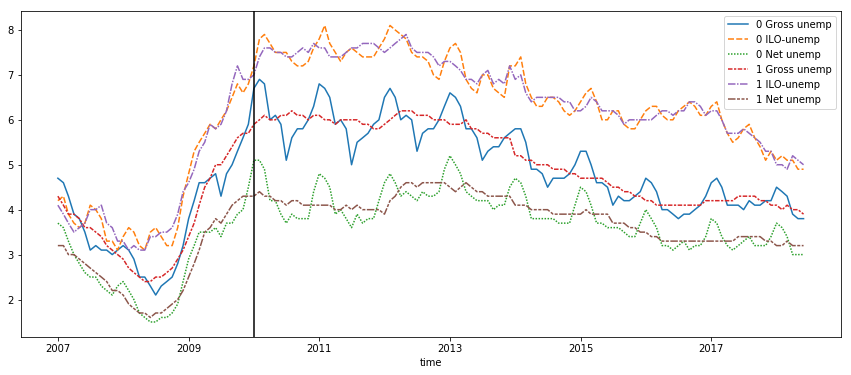

In [39]:
fig, ax = plt.subplots(figsize = (14.7, 6))
sns.lineplot(ax=ax, data= unemp_wide)
plt.axvline(x="2010-01-01", color = "black")

### Net unemployment (first differenced)

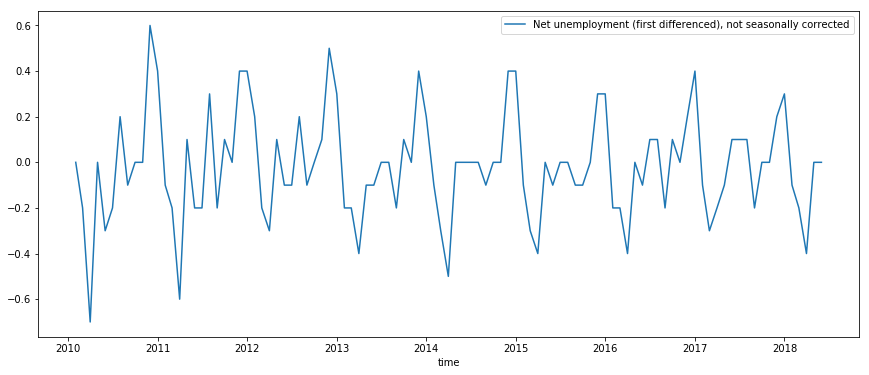

In [40]:
n_unemploy = unemp_wide['0 Net unemp']['2010-01-01':].copy()
n_unemploy = pd.DataFrame(n_unemploy)
n_unemploy['n_unemp_fd'] = (n_unemploy)-(n_unemploy.shift(1))
n_unemp_fd = n_unemploy.drop(columns='0 Net unemp')

fig, ax = plt.subplots(figsize = (14.7, 6))
sns.lineplot(ax=ax, data=n_unemp_fd, legend = None, color="green")
plt.legend(labels = ["Net unemployment (first differenced), not seasonally corrected"])

# Decision Tree plot

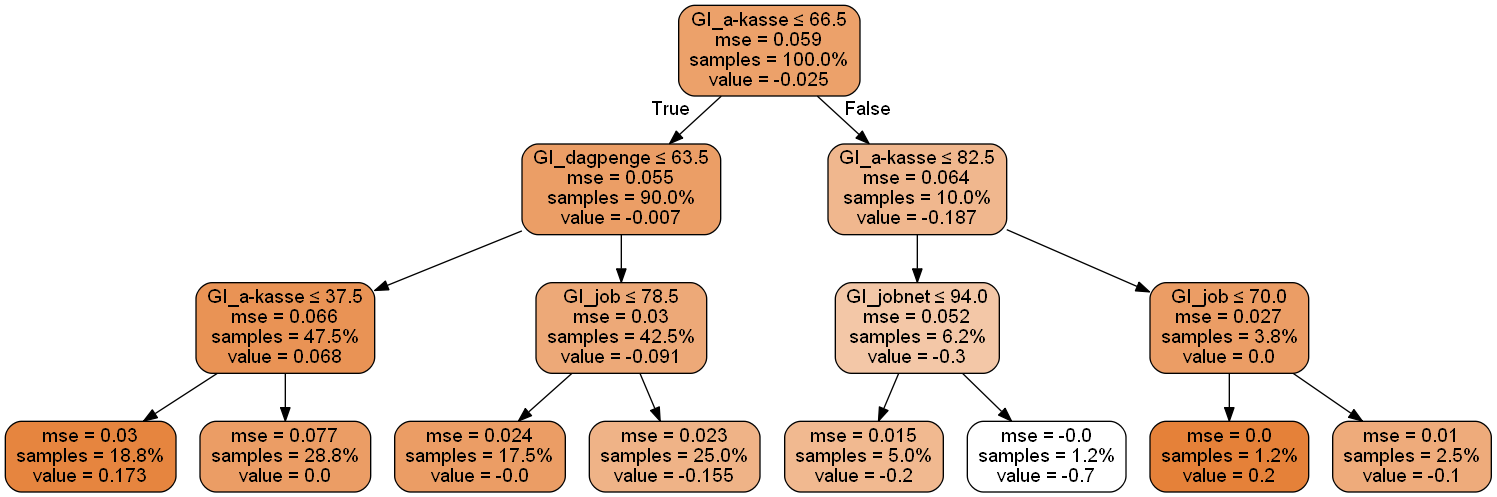

In [41]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import graphviz

import os
# os.environ["PATH"] += os.pathsep + r'C:\Program Files (x86)\Graphviz2.38\bin'
# We had problems with the location of Graph Viz, therefore the line above.
from sklearn.tree import export_graphviz
import pydotplus, collections

dot_data = StringIO()

export_graphviz(tree, out_file=dot_data, proportion = True,
                feature_names = ['GI_job', 'GI_dagpenge', 'GI_kontanthjælp', 'GI_a-kasse', 'GI_jobnet'], 
                filled=True, rounded=True,
                special_characters=True, 
               )
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png())
#graph.write_png('tree.png')

#### Keyword GI plots

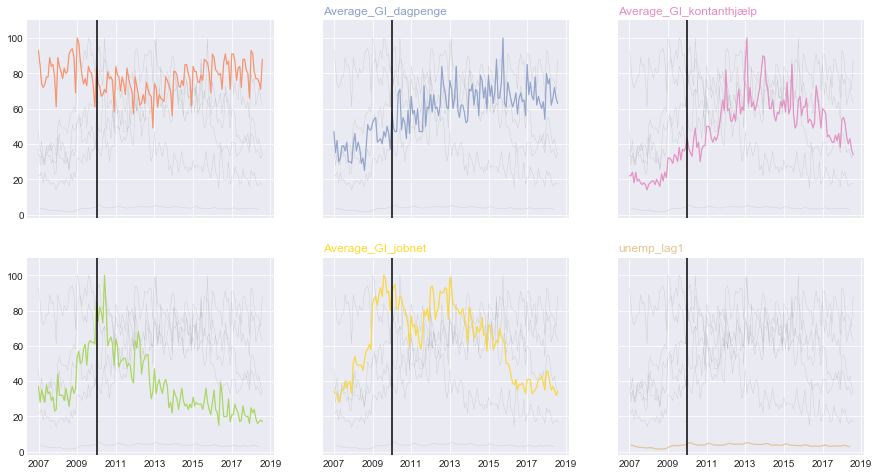

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Make a data frame
#df=pd.DataFrame({'x': range(1,11), 'y1': np.random.randn(10), 'y2': np.random.randn(10)+range(1,11), 'y3': np.random.randn(10)+range(11,21), 'y4': np.random.randn(10)+range(6,16), 'y5': np.random.randn(10)+range(4,14)+(0,0,0,0,0,0,0,-3,-8,-6), 'y6': np.random.randn(10)+range(2,12), 'y7': np.random.randn(10)+range(5,15), 'y8': np.random.randn(10)+range(4,14), 'y9': np.random.randn(10)+range(4,14) })
 
dfGIx = dfGI.assign(Date=pd.to_datetime(dfGI[['Year', 'Month']].assign(day=1)))

dfGIx = dfGIx.drop(columns = ['Year', 'Month'])

# Initialize the figure
fig = plt.figure(figsize=(15,8))
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set2')
 
# multiple line plot
num=0
for column in dfGIx.drop('Date', axis=1):
    num+=1
    
    # Find the right spot on the plot
    plt.subplot(2,3, num)
    
    # plot every groups, but discreet
    for v in dfGIx.drop('Date', axis=1):
        plt.plot(dfGIx['Date'], dfGIx[v], marker='', color='grey', linewidth=0.4, alpha=0.3)
        
    # Plot the lineplot
    plt.plot(dfGIx['Date'], dfGIx[column], marker='', color=palette(num),  \
             linewidth=1.2, alpha=0.9, label=column)
    
    plt.axvline(x="2010-01-01", color = "black")
     
    plt.ylim(-2,110)

    #Not ticks everywhere
    if num in range(4):
        plt.tick_params(labelbottom=False, direction = 'out')
    if num not in [1,4]:
        plt.tick_params(labelleft=False)

        plt.title(column, loc='left', fontsize=12, fontweight=0, color=palette(num) )
 

In [43]:
# all the data
lasso_y_pred = pd.DataFrame(y_pred_ts_lasso)
ridge_y_pred = pd.DataFrame(y_pred_ts_ridge)
AR_y_pred = pd.DataFrame(OLS_pred).shift(1)
DecTree_y_pred = pd.DataFrame(DecTree_pred)
RF_y_pred = pd.DataFrame(RF_pred)
y_test_ts = pd.DataFrame(y_test_ts)
all_y_pred = [y_test_ts, AR_y_pred, lasso_y_pred, ridge_y_pred, DecTree_y_pred, RF_y_pred]

# month and year columns
bb = dfGI.assign(Date=pd.to_datetime(dfGI[['Year', 'Month']].assign(day=1)))
bb = bb.drop(['Average_GI_job', 'Average_GI_dagpenge', 'Average_GI_kontanthjælp', 'Average_GI_akasse', 'Average_GI_jobnet'], axis=1)
bx = bb[bb['Year'] >= 2016]
bx = (bx[1:]).reset_index(drop=True)

all_1 = pd.concat(all_y_pred, axis=1)
all_1.columns = ['y_test','AR(1)_y_pred', 'lasso_y_pred', 'ridge_y_pred', 'DecTree_y_pred', 'RF_y_pred']
all_dat_data = pd.concat([bx, all_1], axis=1)
all_dat_data.head(3)

,Year,Month,unemp_lag1,Date,y_test,AR(1)_y_pred,lasso_y_pred,ridge_y_pred,DecTree_y_pred,RF_y_pred
0,2016,2,4.0,2016-02-01,0.1,NaN,-0.132664,-0.235345,-0.155,-0.097382
1,2016,3,3.8,2016-03-01,0.0,0.030297,-0.086219,-0.123189,-0.155,-0.056087
2,2016,4,3.6,2016-04-01,0.2,0.000000,-0.104376,-0.127798,-0.155,-0.114796


True

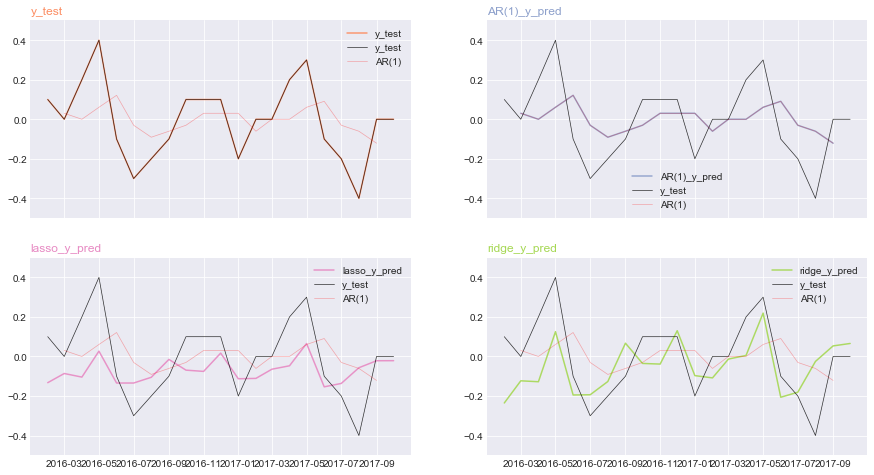

In [45]:
# Initialize the figure
fig = plt.figure(figsize=(15,8))
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set2')
 
# multiple line plot
num=0
for column in all_dat_data.iloc[:,4:8]:
    num+=1
    
    plt.subplot(2, 2, num)
    
    # plot every group, but discreet
    #for v in all_dat_data.iloc[:,2:6]:
    #    plt.plot(all_dat_data['Date'], all_dat_data[v], marker='', color='grey', linewidth=0.4, alpha=0.3)
    
    # Plot the lineplot
    plt.plot(all_dat_data['Date'], all_dat_data[column], marker='', color=palette(num),  \
             linewidth=1.5, alpha=0.9, label=column)
    plt.plot(all_dat_data['Date'], all_dat_data['y_test'], marker='', color='black', \
            linewidth=0.7, alpha=0.8, label='y_test')
    plt.plot(all_dat_data['Date'], all_dat_data['AR(1)_y_pred'], marker='', color='red', \
            linewidth=0.7, alpha=0.3, label="AR(1)", )
    
    plt.ylim(-0.5,0.5)

    #Not ticks everywhere
    if num in range(3):
        plt.tick_params(labelbottom=False, direction = 'out')

    plt.title(column, loc='left', fontsize=12, fontweight=0, color=palette(num) )

    plt.legend() 
    
Image(graph.create_png())
graph.write_png('results.png')